In [1]:
import numpy as np
import pandas
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor,BaggingRegressor
URL = 'colo.xlsx'
df_total = pandas.read_excel(URL,sheetname=0)

In [32]:
df_false = df_total[:]
df_false = df_false[df_false.Level != True]
del df_false['EvType']
del df_false['PromoCategory']
del df_false['PromoType']
del df_false['EndTime']
#Taggin 'Movies / Plays' into Movie
Description = df_false['Description'].values
for i in range(len(df_false['Description'].values)):
    if df_false['ProgrammeTheme'].values[i] == 'Movies / Plays':
         Description[i] = 'Movies'
    if '1 Hour Special' in df_false['Description'].values[i]:
        Description[i] = df_false['Description'].values[i].replace('- 1 Hour Special','').strip()       
df_false['Description'] = Description

#Prior and Subsequent programs 
priorProgram = []
subsequentProgram = []
for i in range(1,len(df_false['Description'].values)-1):
    priorProgram.append(df_false['Description'].values[i-1])
    subsequentProgram.append(df_false['Description'].values[i+1])
df_false =df_false.drop(df_false.index[[0]])
df_false =df_false.drop(df_false.index[[len(df_false['Description'].values)-1]])
df_false['priorProgram'] = priorProgram 
df_false['subsequentProgram'] =  subsequentProgram




#Categerizing the channels
df_PR = df_total[:]
df_PR = df_PR[df_PR.Level != True]
df_PR = df_PR[['Description','Impressions','ProgrammeTheme']]
Description = df_PR['Description'].values
for i in range(len(df_PR['Description'].values)):
    if df_PR['ProgrammeTheme'].values[i] == 'Movies / Plays':
         Description[i] = 'Movies'
    if '1 Hour Special' in df_PR['Description'].values[i]:
        Description[i] = df_PR['Description'].values[i].replace('- 1 Hour Special','').strip()  
df_PR['Description'] = Description
A = np.unique(df_PR['Description'].values)
PI = {}
for i in A:
    PI[i] = []
    for j in range(len(df_PR['Description'].values)):
        if df_PR['Description'].values[j] == i:
            PI[i].append(df_PR['Impressions'].values[j])
PI_AVG = {}
for i in A:
    PI_AVG[i] = np.mean(PI[i])
    
clus = []
for i in PI_AVG.values()[1:]:
    clus.append([i])
from sklearn.cluster import KMeans
clu = KMeans(n_clusters=6,n_init = 100,precompute_distances=False,n_jobs=1) #----------------- NO OF CLUSTERS ------------------>
clu.fit(clus)
Description_classified_prior = df_false['priorProgram'].values
for i in range(len(df_false['priorProgram'].values)):
    Description_classified_prior[i] = clu.predict(PI_AVG[df_false['priorProgram'].values[i]])[0]
Description_classifiedsubsequent =df_false['subsequentProgram'].values
for i in range(len(df_false['subsequentProgram'].values)):
    Description_classifiedsubsequent[i] = clu.predict(PI_AVG[df_false['subsequentProgram'].values[i]])[0]
df_false['priorProgram'] = Description_classified_prior
df_false['subsequentProgram'] = Description_classifiedsubsequent
df_false.priorProgram= df_false.priorProgram.astype(str) 
df_false.subsequentProgram= df_false.subsequentProgram.astype(str)
#Deleting and string conversion
df_false.Date = df_false.Date.astype(str)                    #Changing the Date as String 
df_false.ProgrammeTheme= df_false.ProgrammeTheme.astype(str) #Changing the Programme Theme in String for encoding 
df_false.ProgrammeGenre= df_false.ProgrammeGenre.astype(str) #Changing the Programme Gerne in String for encoding 
df_false.StartTime= df_false.StartTime.astype(str) 
df_false.Length= df_false.Length.astype(str)

del df_false['Description']




#Length Dealing
ftr = [3600,60,1]
leng_seconds = [int(sum([a*b for a,b in zip(ftr, map(int,i.split(':')))])) for i in df_false['Length'].values]
df_false['Length'] = leng_seconds#----------------------------------------------------------------------------------len in Seconds----------------->
#Date Dealing
month = [map(int,i.split('-'))[1] for i in df_false['Date'].values]
day = [map(int,i.split('-'))[2] for i in df_false['Date'].values]
df_false['Month'] = month       #----------------------------------------------------------------------------------Month--------->
df_false['day'] = day           #------------------------------------------------------------------------------------Day--------->
#Weekday dealing
weekday = []
import datetime
for i in df_false['Date'].values:
    year, month, day = (int(x) for x in i.split('-'))    
    ans = datetime.date(year, month, day)
    weekday.append(ans.strftime("%A"))
df_false['weekday'] = weekday  #---------------------------------------------------------------------------------------WeekdaysX------------>
#Binary weekdays dealing
binary_weekday = weekday[:]
for i in range(len(weekday)):
    if weekday[i] == 'Saturday':
        binary_weekday[i] = 'Yes'
    elif weekday[i] == 'Sunday':
        binary_weekday[i] = 'Yes'
    else:
        binary_weekday[i] = 'No'
df_false['B_weekday'] = binary_weekday #--------------------------------------------------------------------------------Binary weekend------>
#del df_false['Date'] #-----------------------------------------------------------------------------------------------Deleting Date------
#StartTime Dealing
Starttime = df_false['StartTime'].values
for i in range(len(df_false['StartTime'].values)):
    if len(df_false['StartTime'].values[i].split()) == 2:     
        Starttime[i] =  df_false['StartTime'].values[i].split()[1]    
df_false['StartTime'] = Starttime #------------------------------------------------------------------------------------------Start time
df_false['hour'] = [map(int,i.split(':'))[0] for i in df_false['StartTime'].values]#--------------------hour------------------------------->
df_false.hour= df_false.hour.astype(str)
df_false['StartTime'] = [map(int,i.split(':'))[0]+ map(int,i.split(':'))[1]/60.0+map(int,i.split(':'))[1]/3600.0 for i in df_false['StartTime'].values]


#Decision channel
df = df_false[:]
#Creating a array for impression Prediction 
#del df['Impressions']

#del df['StartTime'] #-------------------------------------------------------------------------------------------deleting starttime------>#
#del df['priorProgram'] #---------------------------------------------------------------------------------- -----prior programme--------->
#del df['subsequentProgram']#-------------------------------------------------------------------------- ----- ---subsequent programme
#del df['Length'] #---------------------------------------------------------------------------------------------del length -------------->
#del df['ProgrammeTheme'] #-------------------------------  ---------------------------------------------------- programe theme------->
#del df['ProgrammeGenre'] #------------------------------------------------------------------------------------- ProgrammeGenre------->
del df['B_weekday'] #---------------------------------------------------------------  --------------------------B-weekend------>

del df['hour'] #-----------------------------------------------------------------------  ------------------------Hour--------->
#del df['weekday'] #---------------------------------------------------------------------- -----------------------weekday-------->
#del df['day'] #-------------------------------------------------------------------------- ------------------------day------->
#del df['Month'] #-------------------------------------------------------------------------------------------------Month------>
df.Month= df.Month.astype(str)
del df['Date']
del df['Level']

In [43]:
data = np.zeros(len(df))
data[0] = 1
for i in range(len(df)-1):
    if df['day'].values[i+1] == df['day'].values[i]:
        data[i+1] = data[i]
    else:
        data[i+1] = data[i]+1  

In [44]:
df['Week'] = data

In [33]:
df

,ProgrammeTheme,ProgrammeGenre,StartTime,Length,Impressions,Week,priorProgram,subsequentProgram,Month,day,weekday
1,Serials/Series - Fiction,Drama / Family,3.016944,1687,13.49,1,3,0,10,12,Monday
2,Serials/Series - Fiction,Drama / Family,3.491389,1901,0.38,1,3,0,10,12,Monday
3,Serials/Series - Fiction,Drama / Family,4.016944,1896,27.17,1,0,0,10,12,Monday
4,Serials/Series - Fiction,Drama / Family,4.542222,1660,47.71,1,0,5,10,12,Monday
5,Serials/Series - Fiction,Drama / Family,5.525278,1773,34.48,1,0,1,10,12,Monday
6,Serials/Series - Fiction,Drama / Family,7.982778,3550,471.12,1,5,0,10,12,Monday
7,Serials/Series - Fiction,Drama / Family,8.965833,1828,925.71,1,1,5,10,12,Monday
8,Serials/Series - Fiction,Drama / Family,9.457500,1999,1603.25,1,0,5,10,12,Monday
9,Serials/Series - Fiction,Drama / Family,10.016944,1731,1367.17,1,5,0,10,12,Monday
10,Serials/Series - Fiction,Drama / Family,10.508333,1700,1558.90,1,5,3,10,12,Monday


In [34]:
del df['day'] 
Y_pred = {}
for i in range(9,20,1):
    df_tr = df[df['Week'].isin(np.arange(0,i,1))]
    df_te = df[df['Week'].isin(np.arange(i,i+2,1))]
    week = df_te['Week'].values     
    del df_tr['Week']
    del df_te['Week']
    Y_train = df_tr['Impressions'].values
    Y_test = df_te['Impressions'].values
    #del df_tr['DAYNumber']
    #del df_te['DAYNumber']
    #ENCODING
    X_train = df_tr.to_dict('records')
    X_test = df_te.to_dict('records')
    X_tr = []
    X_te = []
    X_tr.extend(X_train)
    X_te.extend(X_test)
    X_total = X_tr + X_te
    #One Hot Encoding 
    enc = DictVectorizer()
    X_encoded_total =enc.fit_transform(X_total)
    X_encoded_train =X_encoded_total[:len(X_tr)]
    X_encoded_test =X_encoded_total[len(X_tr):]
    #Extra Trees
    reg1 = RandomForestRegressor()
    reg1.fit(X_encoded_train,Y_train)
    #Y_pred[10] = reg1.predict(X_encoded_test)[:list(week).count(10)]
    Y_pred[i+1] = reg1.predict(X_encoded_test)[list(week).count(i):]

In [26]:
Y_pred

{10: array([  4.42000000e-01,   4.00000000e-02,   2.98000000e-01,
          5.16000000e-01,   2.67200000e+00,   4.50688000e+02,
          1.22816000e+03,   7.74817000e+02,   7.74682000e+02,
          1.42154900e+03,   8.67147000e+02,   7.70071000e+02,
          1.55069500e+03,   1.45574400e+03,   1.06007900e+03,
          6.79806000e+02,   9.78186000e+02,   7.81631000e+02,
          9.28491000e+02,   2.22294700e+03,   5.26606100e+03,
          8.17003000e+03,   1.00152500e+04,   6.26946300e+03,
          6.87819400e+03,   5.36813500e+03,   6.37727200e+03,
          3.39074800e+03,   1.60823400e+03,   3.74873000e+02,
          1.09557000e+02,   8.85000000e+00,   6.07200000e+00,
          8.98400000e+00,   4.07500000e+00,   1.35360000e+01,
          1.41170000e+01,   2.71866000e+02,   3.25492000e+02,
          8.00010000e+02,   7.08336000e+02,   7.37061000e+02,
          6.23306000e+02,   1.55355500e+03,   1.00348100e+03,
          9.71427000e+02,   1.30158900e+03,   1.74825600e+03,
    

In [45]:
Y_pred = {}
del df['day'] 
df_tr = df[df['Week'].isin(np.arange(0,60,1))]
df_te = df[df['Week'].isin(np.arange(60,62,1))]
week = df_te['Week'].values     
del df_tr['Week']
del df_te['Week']
Y_train = df_tr['Impressions'].values
Y_test = df_te['Impressions'].values
#ENCODING
X_train = df_tr.to_dict('records')
X_test = df_te.to_dict('records')
X_tr = []
X_te = []
X_tr.extend(X_train)
X_te.extend(X_test)
X_total = X_tr + X_te
#One Hot Encoding 
enc = DictVectorizer()
X_encoded_total =enc.fit_transform(X_total)
X_encoded_train =X_encoded_total[:len(X_tr)]
X_encoded_test =X_encoded_total[len(X_tr):]
#Extra Trees
reg1 = RandomForestRegressor()
reg1.fit(X_encoded_train,Y_train)
Y_pred[60] = reg1.predict(X_encoded_test)[:list(week).count(60)]
Y_pred[61] = reg1.predict(X_encoded_test)[list(week).count(60):]
for i in range(61,68,1):
    import warnings
    warnings.filterwarnings('ignore')
    df_tr_inter = df_tr[:]
    df_tr_inter['Impressions'] = Y_train
    df_te_inter = df_te[:]
    df_te_inter['week'] = week
    #df_te_inter['actual'] = Y_test
    df_te_inter['Impressions'] = list(Y_pred[i]) +list(Y_pred[i-1])
    df_te_inter = df_te_inter[df_te_inter['week'].isin([i-1])]
    del df_te_inter['week']
    frames = [df_tr_inter, df_te_inter]
    df_tr_1 = pandas.concat(frames) 
    df_te_1 = df[df['Week'].isin(np.arange(i,i+2,1))]
    week = df_te_1['Week'].values     
    del df_te_1['Week']
    Y_train_1 = df_tr_1['Impressions'].values
    Y_test_1 = df_te_1['Impressions'].values
    del df_tr_1['Impressions']
    del df_te_1['Impressions']
    #ENCODING
    X_train = df_tr_1.to_dict('records')
    X_test = df_te_1.to_dict('records')
    X_tr = []
    X_te = []
    X_tr.extend(X_train)
    X_te.extend(X_test)
    X_total = X_tr + X_te
    #One Hot Encoding 
    enc = DictVectorizer()
    X_encoded_total =enc.fit_transform(X_total)
    X_encoded_train =X_encoded_total[:len(X_tr)]
    X_encoded_test =X_encoded_total[len(X_tr):]
    #Extra Trees
    reg1 = RandomForestRegressor()
    reg1.fit(X_encoded_train,Y_train_1)
    Y_pred[i+1] = reg1.predict(X_encoded_test)[list(week).count(i):]
    df_tr = df_tr_1
    Y_train = Y_train_1
    df_te =df_te_1 

In [25]:

for i in range(11,21,1):
    import warnings
    warnings.filterwarnings('ignore')
    df_tr_inter = df_tr[:]
    df_tr_inter['Impressions'] = Y_train
    df_te_inter = df_te[:]
    df_te_inter['week'] = week
    #df_te_inter['actual'] = Y_test
    df_te_inter['Impressions'] = list(Y_pred[i]) +list(Y_pred[i-1])
    df_te_inter = df_te_inter[df_te_inter['week'].isin([i-1])]
    del df_te_inter['week']
    frames = [df_tr_inter, df_te_inter]
    df_tr_1 = pandas.concat(frames) 
    df_te_1 = df[df['Week'].isin(np.arange(i,i+2,1))]
    week = df_te_1['Week'].values     
    del df_te_1['Week']
    Y_train_1 = df_tr_1['Impressions'].values
    Y_test_1 = df_te_1['Impressions'].values
    del df_tr_1['Impressions']
    del df_te_1['Impressions']
    #ENCODING
    X_train = df_tr_1.to_dict('records')
    X_test = df_te_1.to_dict('records')
    X_tr = []
    X_te = []
    X_tr.extend(X_train)
    X_te.extend(X_test)
    X_total = X_tr + X_te
    #One Hot Encoding 
    enc = DictVectorizer()
    X_encoded_total =enc.fit_transform(X_total)
    X_encoded_train =X_encoded_total[:len(X_tr)]
    X_encoded_test =X_encoded_total[len(X_tr):]
    #Extra Trees
    reg1 = RandomForestRegressor()
    reg1.fit(X_encoded_train,Y_train_1)
    Y_pred[i+1] = reg1.predict(X_encoded_test)[list(week).count(i):]
    df_tr = df_tr_1
    Y_train = Y_train_1
    df_te =df_te_1 

KeyError: 59

In [35]:
df_t = df[df['Week'].isin(np.arange(10,21,1))]
Y  = df_t['Impressions'].values

In [38]:
len(X)

2279

In [37]:
X = []
for i in range(10,21,1):
    X.extend(Y_pred[i])

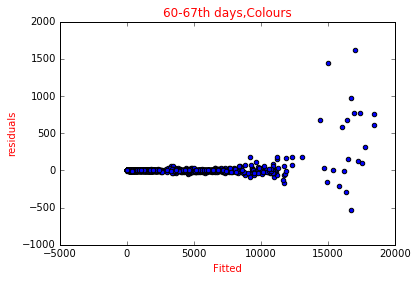

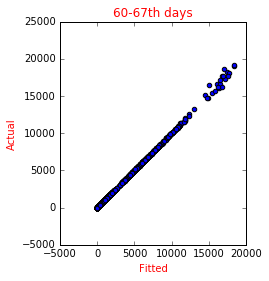

MAE =  8.8734918824
RMSE =  66.4233453869
r2 = 0.999508069826
MAPE 0.00404811004667
ME =  -4.05935059237


In [39]:
Y_p = X
Y_t = Y
MAPE = []
ME = []
for i in range(len(Y_t)):
    ME.append(float(Y_p[i])- Y_t[i])
    if (Y_p[i] - Y_t[i]) == 0:
        MAPE.append(0)
    elif Y_t[i] == 0:
        MAPE.append(1)
    else:
        MAPE.append(abs((Y_p[i] - Y_t[i])/Y_t[i]))
import numpy as np
import matplotlib.pyplot as plt
#OUR DATA
%matplotlib inline
A = 100
X = np.arange(A)
Y = Y_t[:A]
x = np.arange(A)
y = Y_p[:A]
####################
from matplotlib import pyplot as plt
canvas = plt.figure()
rect = canvas.patch
rect.set_facecolor('white')
sp1 = canvas.add_subplot(1,1,1, axisbg='w')
sp1.scatter(Y_p,Y_t-Y_p)
sp1.set_title('60-67th days,Colours', color='red')
sp1.set_xlabel('Fitted', color='red')      #Colour of title and lables 
sp1.set_ylabel('residuals', color='red')
#sp1.axes().set_aspect('equal', 'datalim')
plt.show()

from matplotlib import pyplot as plt
canvas = plt.figure()
rect = canvas.patch
rect.set_facecolor('white')
sp1 = canvas.add_subplot(1,1,1, axisbg='w')
sp1.scatter(Y_p,Y_t)
sp1.set_title('60-67th days', color='red')
sp1.set_xlabel('Fitted', color='red')      #Colour of title and lables 
sp1.set_ylabel('Actual', color='red')
plt.axis('scaled')
plt.show()

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
print "MAE = ", mean_absolute_error(Y_t,Y_p)
print "RMSE = ",(mean_squared_error(Y_t,Y_p))**0.5
print "r2 =", r2_score(Y_t,Y_p)
print "MAPE",sum(MAPE)/len(Y_p)
print "ME = ",sum(ME)/len(Y_p)

In [43]:
len(X)

200

ValueError: x and y must have same first dimension

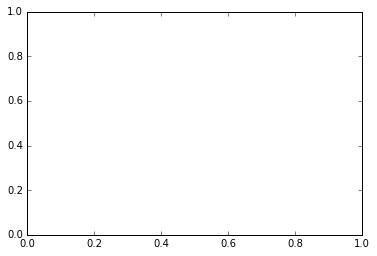

In [41]:
import numpy as np
import matplotlib.pyplot as plt
#OUR DATA
Y_grad_1 = X
Y_vald_1 =  Y
A = 200
X = np.arange(A)
Y = Y_vald_1[:A]
x = np.arange(A)
y = Y_grad_1[:A]
####################
#Visuvalization
canvas = plt.figure()
rect = canvas.patch
rect.set_facecolor('white')
sp1 = canvas.add_subplot(1,1,1, axisbg='w')
sp1.plot(x, y, 'Red', linewidth=2)
sp1.plot(X, Y, 'Black', linewidth=1)

sp1.patch.set_facecolor('white') #------> background colour

sp1.tick_params(axis='x', colors='green') #---------> X-value colour
sp1.tick_params(axis='y', colors='red') #----------> y-value colour

sp1.spines['bottom'].set_color('black')        #Colour of spines 
sp1.spines['top'].set_visible('False')
sp1.spines['left'].set_color('black')
sp1.spines['right'].set_visible('False')

sp1.set_title('Impressions vs time Using Extra Classifier', color='red')
sp1.set_xlabel('Time,BLUE -Actual', color='red')      #Colour of title and lables 
sp1.set_ylabel('Impression', color='red')
plt.plot(X,Y)
plt.plot(x,y)

plt.tight_layout()
plt.show()

In [137]:
from pandas import ExcelWriter
writer = ExcelWriter('output.xlsx')
df_t.to_excel(writer,'Sheet1')
writer.save()